<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 📈 Analyse statistique / Recettes / Long-Terme

In [1]:
import sys
sys.path.append('..')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

if '_data_utils' in sys.modules:
    import _data_utils
    importlib.reload(_data_utils)
    if hasattr(_data_utils, 'data_utils_recipes'):
        importlib.reload(_data_utils.data_utils_recipes)

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

✅ RAW_RECIPES chargée : 231,637 lignes × 12 colonnes
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 Ingrédients : médiane=9, moyenne=8.8, max=17
📅 Période : 1999-08-06 → 2018-12-04 (19 ans)



## Analyse statistique

### Analyse 1 : Volume de recettes
#### Visualisation

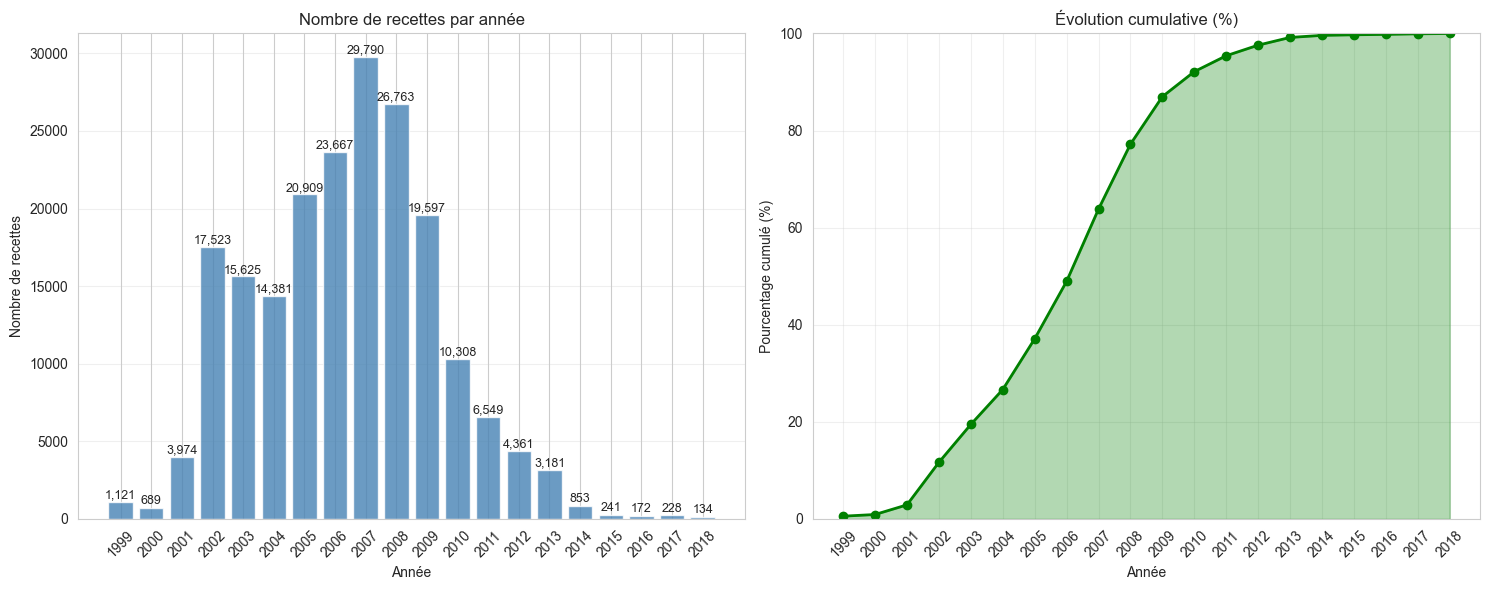

In [3]:
recipes_per_year = (df.group_by("year").agg(pl.len().alias("n_recipes")).sort("year").to_pandas())
# Visualization
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(15, 6))
bars = ax1.bar(recipes_per_year['year'].astype(int), recipes_per_year['n_recipes'], 
               color='steelblue', alpha=0.8)
ax1.set_title('Nombre de recettes par année')
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de recettes')
ax1.set_xticks(recipes_per_year['year'].astype(int))
ax1.set_xticklabels(recipes_per_year['year'].astype(int), rotation=45)
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, recipes_per_year['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=9)

cumulative = recipes_per_year['n_recipes'].cumsum()
total_recipes = cumulative.iloc[-1]  
cumulative_pct = (cumulative / total_recipes) * 100

ax0.plot(recipes_per_year['year'].astype(int), cumulative_pct, 
         marker='o', linewidth=2, color='green', markersize=6)
ax0.fill_between(recipes_per_year['year'].astype(int), cumulative_pct, 
                 alpha=0.3, color='green')
ax0.set_title('Évolution cumulative (%)')
ax0.set_xlabel('Année')
ax0.set_ylabel('Pourcentage cumulé (%)')
ax0.set_ylim(0, 100)
ax0.set_xticks(recipes_per_year['year'].astype(int))
ax0.set_xticklabels(recipes_per_year['year'].astype(int), rotation=45)
ax0.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

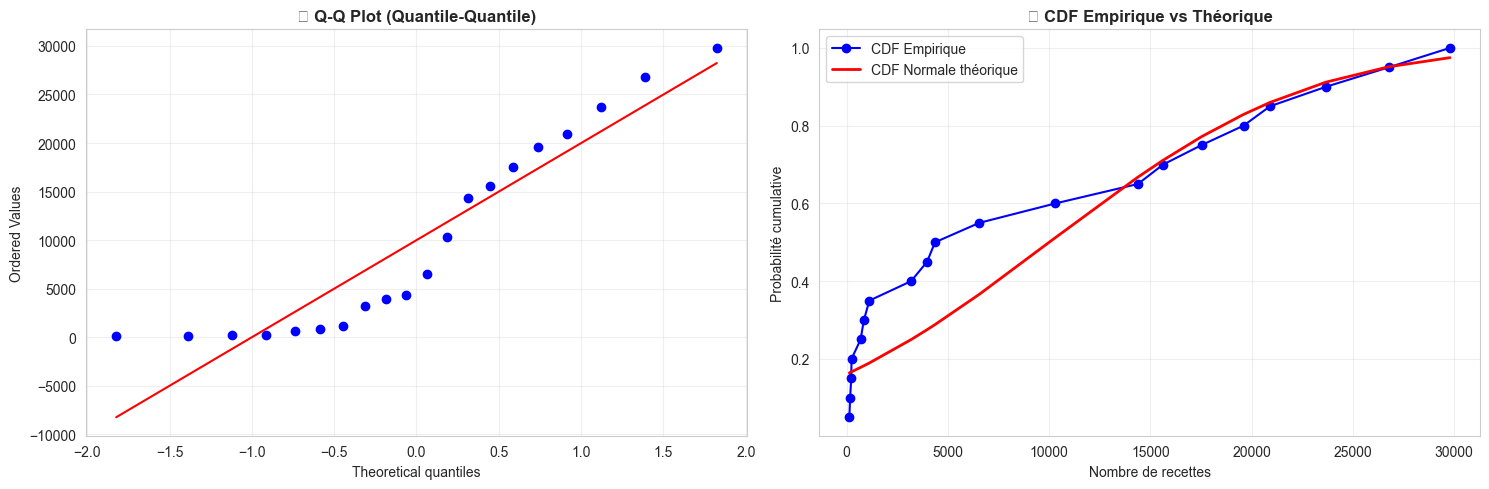


1️⃣ TEST DE SHAPIRO-WILK :
   • Statistique W : 0.861946
   • p-value : 0.008508
   • Résultat : ❌ NON NORMAL (α = 0.05)

2️⃣ TEST DE D'AGOSTINO-PEARSON :
   • Statistique K² : 3.532839
   • p-value : 0.170944
   • Résultat : ✅ NORMAL (α = 0.05)


In [5]:
from scipy.stats import shapiro, normaltest, jarque_bera, kstest
data = recipes_per_year['n_recipes'].values
n = len(data)
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)
ks_stat, ks_p = kstest(data, lambda x: ((x - mean_data) / std_data))

# 📈 VISUALISATION DE LA NORMALITÉ
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax0 = axes[0]
stats.probplot(data, dist="norm", plot=ax0)
ax0.set_title('📈 Q-Q Plot (Quantile-Quantile)', fontweight='bold')
ax0.grid(True, alpha=0.3)

ax1 = axes[1]
sorted_data = np.sort(data)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax1.plot(sorted_data, empirical_cdf, 'o-', label='CDF Empirique', color='blue')
theoretical_cdf = stats.norm.cdf(sorted_data, mean_data, std_data)
ax1.plot(sorted_data, theoretical_cdf, 'r-', linewidth=2, label='CDF Normale théorique')
ax1.set_title('📉 CDF Empirique vs Théorique', fontweight='bold')
ax1.set_xlabel('Nombre de recettes')
ax1.set_ylabel('Probabilité cumulative')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

shapiro_stat, shapiro_p = shapiro(data)
print(f"\n1️⃣ TEST DE SHAPIRO-WILK :")
print(f"   • Statistique W : {shapiro_stat:.6f}")
print(f"   • p-value : {shapiro_p:.6f}")
print(f"   • Résultat : {'✅ NORMAL' if shapiro_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

dagostino_stat, dagostino_p = normaltest(data)
print(f"\n2️⃣ TEST DE D'AGOSTINO-PEARSON :")
print(f"   • Statistique K² : {dagostino_stat:.6f}")
print(f"   • p-value : {dagostino_p:.6f}")
print(f"   • Résultat : {'✅ NORMAL' if dagostino_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")


> **💡 Interprétation:** 
>
> Les **tests de normalité** et les **Q-Q plots** montrent que la distribution du **nombre de recettes par an** **n’est pas parfaitement normale**, avec des **écarts visibles** par rapport à la **loi normale théorique**. 
>
> Le **pic en 2007**, suivi d’une **forte baisse**, crée une **asymétrie marquée** dans les données. Ainsi, la **production de recettes** a connu une **croissance rapide jusqu’en 2007**, puis un **déclin soudain**, ce qui explique la **déviation statistique** par rapport à une **distribution normale**.


### Analyse 2: Évolution de la durée moyenne
#### Visualisation

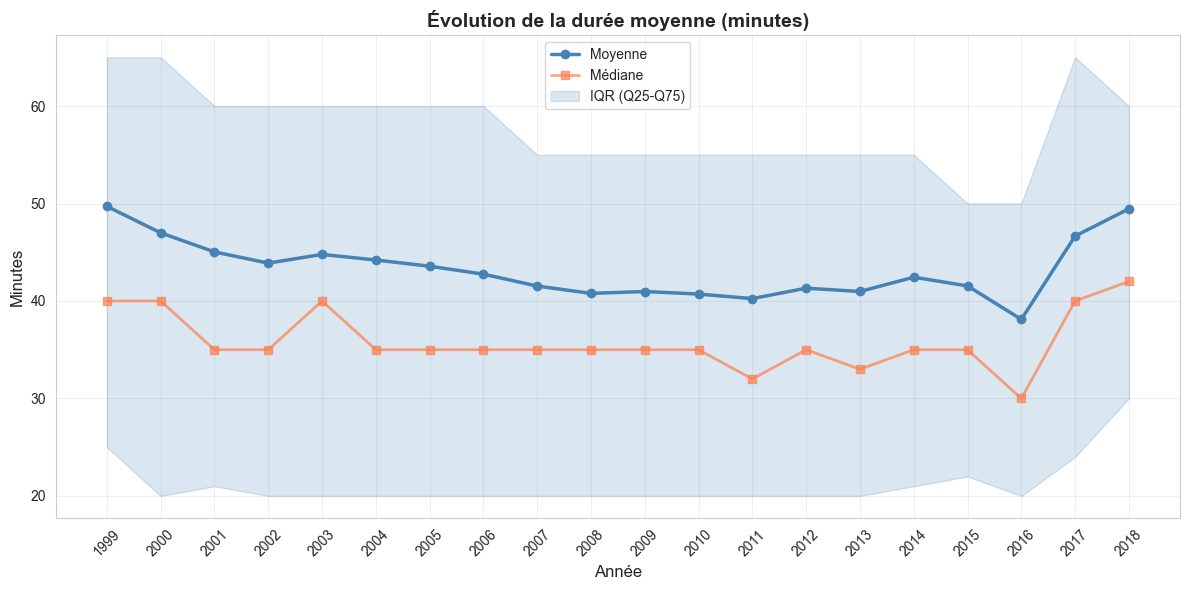

In [9]:
minutes_by_year = (df.group_by("year")
    .agg([pl.mean("minutes").alias("mean_minutes"), pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes", 0.25).alias("q25"), pl.quantile("minutes", 0.75).alias("q75"), pl.len().alias("n_recipes")
    ]).sort("year").to_pandas())
minutes_by_year['IQR'] = minutes_by_year['q75'] - minutes_by_year['q25']
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(minutes_by_year['year'], minutes_by_year['mean_minutes'], marker='o', linewidth=2.5, color='steelblue', label='Moyenne')
ax1.plot(minutes_by_year['year'], minutes_by_year['median_minutes'],marker='s', linewidth=2, color='coral', alpha=0.7, label='Médiane')
ax1.fill_between(minutes_by_year['year'],  minutes_by_year['q25'], minutes_by_year['q75'], alpha=0.2, color='steelblue', label='IQR (Q25-Q75)')
ax1.set_title('Évolution de la durée moyenne (minutes)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Année', fontsize=12)
ax1.set_ylabel('Minutes', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Forcer l'affichage des années en entier
ax1.set_xticks(minutes_by_year['year'])
ax1.set_xticklabels([int(y) for y in minutes_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [10]:
spearman_corr, spearman_p = spearmanr(minutes_by_year['year'], minutes_by_year['mean_minutes'])
X_min = minutes_by_year['year'].values.reshape(-1, 1)
y_min = minutes_by_year['mean_minutes'].values
model_min = LinearRegression().fit(X_min, y_min)
r2_min = model_min.score(X_min, y_min)

print(f"Corrélation de Spearman: {spearman_corr:.4f} (p = {spearman_p:.6f})")
print(f"Tendance: {'✅ Significative' if spearman_p < 0.05 else '❌ Non significative'}")
print(f"Pente: {model_min.coef_[0]:.4f} minutes/année")
print(f"R²: {r2_min:.4f} ({r2_min*100:.1f}% variance expliquée)")

Corrélation de Spearman: -0.4015 (p = 0.079317)
Tendance: ❌ Non significative
Pente: -0.1730 minutes/année
R²: 0.1096 (11.0% variance expliquée)


> **💡 Interprétation :**  
>
> La **corrélation de Spearman** indique une **tendance négative faible et non significative** entre la durée moyenne des recettes et le temps.  
>
> La **pente faible** et le **faible R²** confirment que la **durée moyenne** reste **globalement stable** au fil des années.  
>
> Ainsi, aucune **évolution significative** n’est observée, la **préparation des recettes** demeurant **constante autour de 43 minutes**.


### Analyse 3: Évolution de la complexité
#### Visualisation

In [17]:
# Rappel du score de complexité: complexity_score = log1p(minutes) + n_steps + 0.5 * n_ingredients
# où log1p(m)= log(1+m)

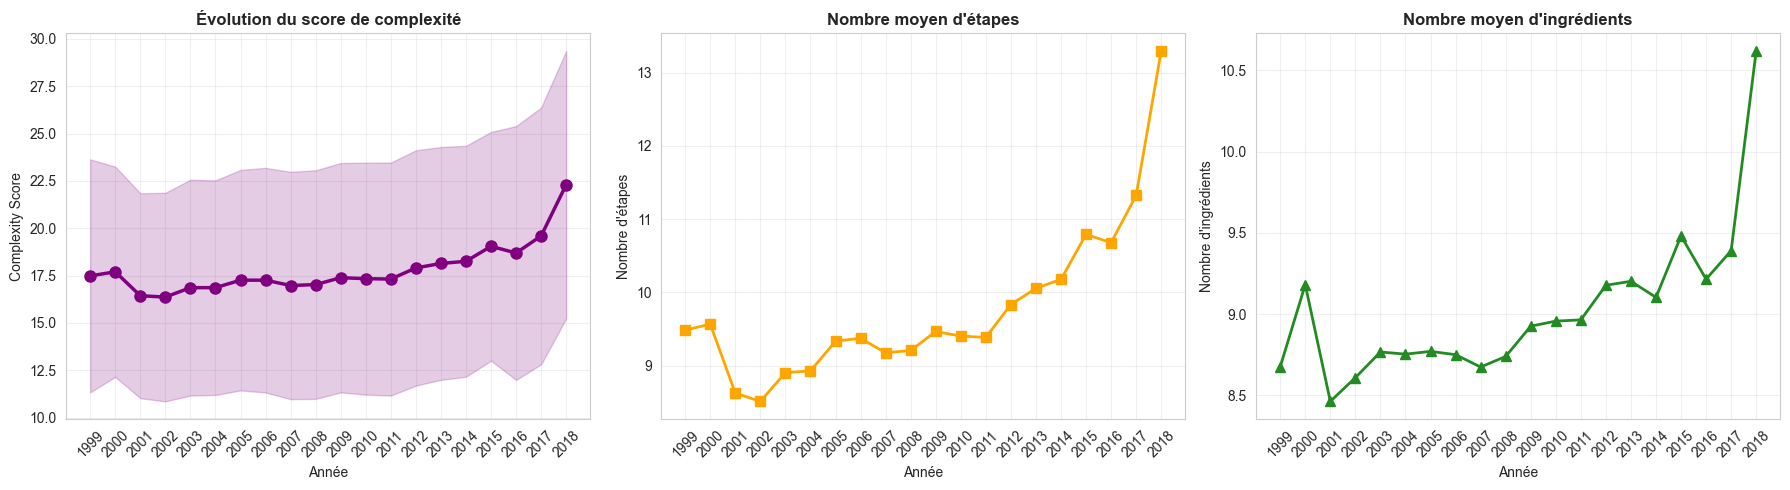

In [19]:
complexity_by_year = (
    df.group_by("year")
    .agg([pl.mean("complexity_score").alias("mean_complexity"), pl.median("complexity_score").alias("median_complexity"),
        pl.std("complexity_score").alias("std_complexity"), pl.mean("n_steps").alias("mean_steps"),
        pl.mean("n_ingredients").alias("mean_ingredients")])
    .sort("year").to_pandas())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(complexity_by_year['year'], complexity_by_year['mean_complexity'], marker='o', linewidth=2.5, color='purple', markersize=8)
axes[0].fill_between(complexity_by_year['year'], 
                      complexity_by_year['mean_complexity'] - complexity_by_year['std_complexity'],
                      complexity_by_year['mean_complexity'] + complexity_by_year['std_complexity'],
                      alpha=0.2, color='purple')
axes[0].set_title('Évolution du score de complexité', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Année'); axes[0].set_ylabel('Complexity Score'); axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(complexity_by_year['year'])
axes[0].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

axes[1].plot(complexity_by_year['year'], complexity_by_year['mean_steps'], marker='s', linewidth=2, color='orange', markersize=7)
axes[1].set_title('Nombre moyen d\'étapes', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Année'); axes[1].set_ylabel('Nombre d\'étapes'); axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(complexity_by_year['year'])
axes[1].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

axes[2].plot(complexity_by_year['year'], complexity_by_year['mean_ingredients'], marker='^', linewidth=2, color='forestgreen', markersize=7)
axes[2].set_title('Nombre moyen d\'ingrédients', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Année'); axes[2].set_ylabel('Nombre d\'ingrédients'); axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(complexity_by_year['year'])
axes[2].set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

In [25]:
# Tests sur l'évolution de la complexité (version compacte)
X = complexity_by_year[['year']].values
y = complexity_by_year['mean_complexity'].values

# Régression linéaire
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
slope = model.coef_[0]

# Corrélation de Spearman
corr, p_value = spearmanr(complexity_by_year['year'], complexity_by_year['mean_complexity'])
if slope > 0.01:
    tendance = f"✅ Complexité en hausse (+{slope:.4f} pts/an)"
elif slope < -0.01:
    tendance = f"✅ Complexité en baisse ({slope:.4f} pts/an)"
else:
    tendance = "➡️ Complexité stable"

print(f"📊 Régression (complexity ~ year): pente={slope:.6f} | R²={r2:.4f}")
print(f"📊 Spearman: ρ={corr:.4f} | p={p_value:.6f} | significatif={'OUI ✅' if p_value < 0.05 else 'NON ❌'}")
print(f"💡 Interprétation: {tendance}")

📊 Régression (complexity ~ year): pente=0.169640 | R²=0.5552
📊 Spearman: ρ=0.7609 | p=0.000098 | significatif=OUI ✅
💡 Interprétation: ✅ Complexité en hausse (+0.1696 pts/an)


> **💡 Interprétation :**  
> 
> La **régression linéaire** (pente = +0.17, R² = 0.56) et la **corrélation de Spearman** (ρ = 0.76, p < 0.001) indiquent une **tendance clairement significative à la hausse** du score de complexité au fil du temps.  
> 
> Cette évolution traduit une **augmentation progressive de la complexité des recettes**, soit environ **+0.17 point par an**, suggérant des **préparations de plus en plus élaborées** au cours des années.  
> 
> L’évolution est **cohérente** avec la hausse parallèle du **nombre moyen d’étapes** et du **nombre d’ingrédients**, confirmant une **complexification globale** des recettes publiées.  


### Analyse 4: Évolution nutritionnelle
#### Visualisation

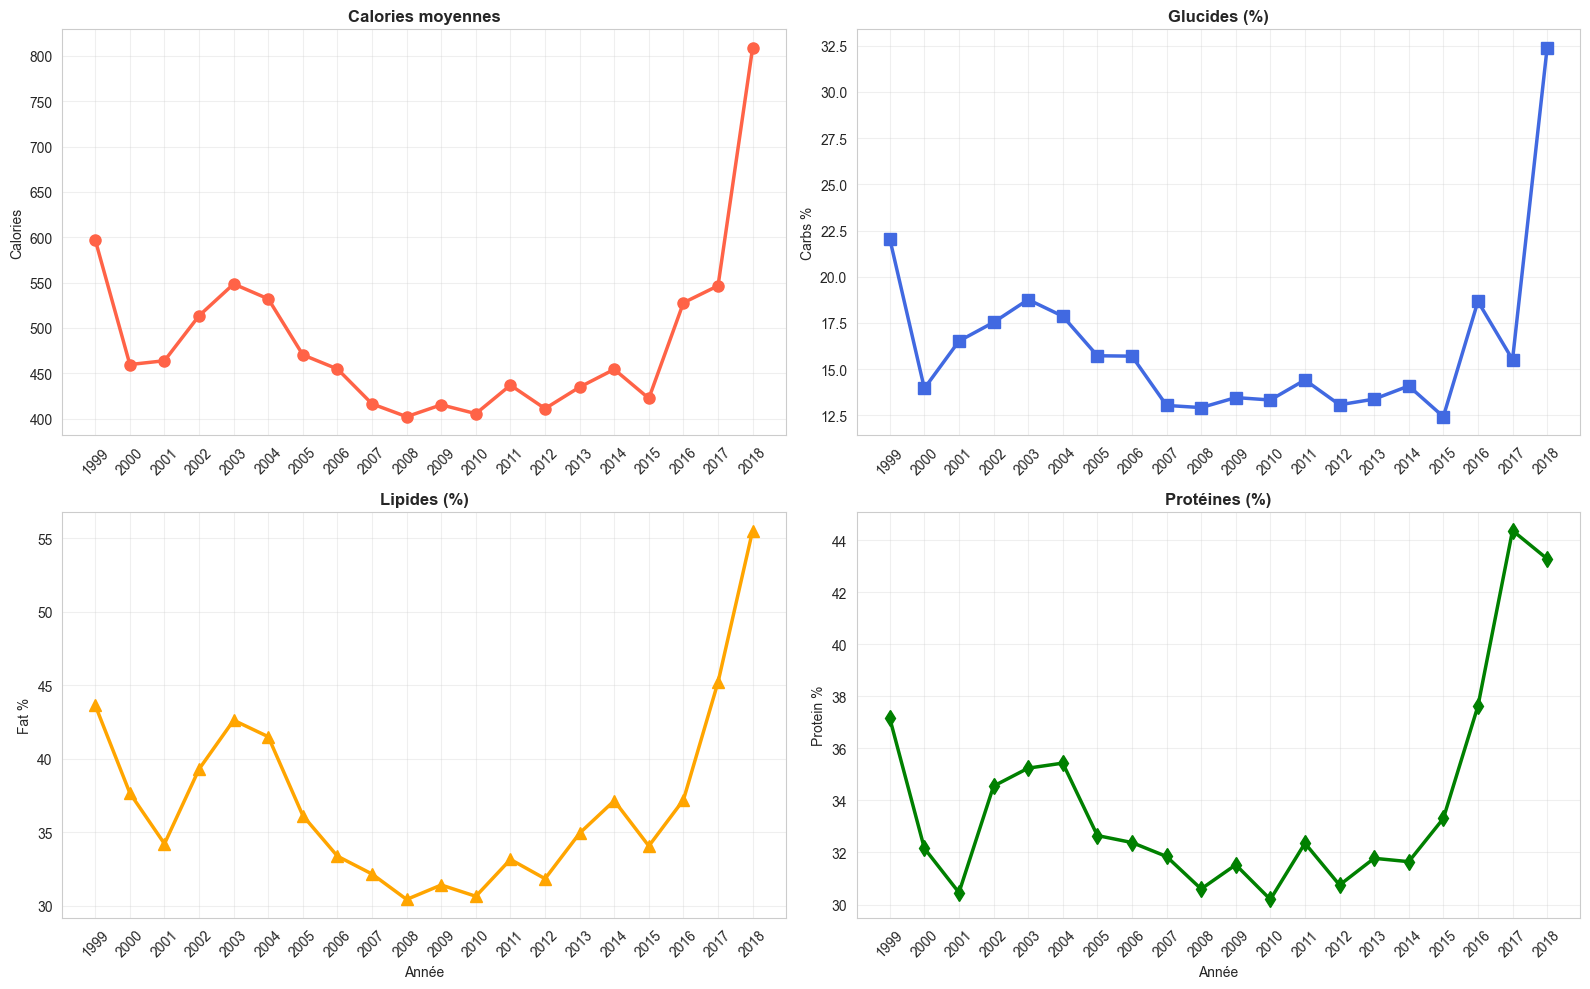

In [34]:
# 📊 Agrégation nutrition par année (Calories, Glucides, Lipides, Protéines)
nutrition_by_year = (
    df.group_by("year")
    .agg([pl.mean("calories").alias("mean_calories"), pl.mean("carb_pct").alias("mean_carbs"), 
          pl.mean("total_fat_pct").alias("mean_fat"), pl.mean("protein_pct").alias("mean_protein")])
    .sort("year").to_pandas())


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes[0,0].plot(nutrition_by_year['year'], nutrition_by_year['mean_calories'], 
               marker='o', linewidth=2.5, color='tomato', markersize=8)
axes[0,0].set_title('Calories moyennes', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Calories')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(nutrition_by_year['year'])
axes[0,0].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[0,1].plot(nutrition_by_year['year'], nutrition_by_year['mean_carbs'], 
               marker='s', linewidth=2.5, color='royalblue', markersize=8)
axes[0,1].set_title('Glucides (%)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Carbs %')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(nutrition_by_year['year'])
axes[0,1].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[1,0].plot(nutrition_by_year['year'], nutrition_by_year['mean_fat'], 
               marker='^', linewidth=2.5, color='orange', markersize=8)
axes[1,0].set_title('Lipides (%)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Année')
axes[1,0].set_ylabel('Fat %')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(nutrition_by_year['year'])
axes[1,0].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

axes[1,1].plot(nutrition_by_year['year'], nutrition_by_year['mean_protein'], 
               marker='d', linewidth=2.5, color='green', markersize=8)
axes[1,1].set_title('Protéines (%)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Année')
axes[1,1].set_ylabel('Protein %')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(nutrition_by_year['year'])
axes[1,1].set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistique et interprétation

### Analyse 5: Évolution des ingrédients
#### Visualisation

#### Tests statistique et interprétation

### Analyse 6: Évolution des tags
#### Visualisation

#### Tests statistique et interprétation